<a href="https://colab.research.google.com/github/danon6868/BI-ml-2023/blob/main/lecture_9_10_cnn/homework/hw_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 1. Свёртка

**5 баллов**

Реализуйте функцию свёртки `conv(x, kernel, stride, pad)`, где:


* $\text{x}$: Двумерный массив размером $(W,H)$;
* $\text{kernel}$: ядро свёртки размером $(K, K)$;
* $\text{stride}$: шаг ядра свёртки. $0 < \text{stride} \leq \min(W,H)$;
* $\text{pad}$: ширина дополнения с каждой из сторон массива. $\text{pad} > 0$.

Результатм работы функции является возвращение следующего значения:
* $out$: Результат свертки входных данных $\text{x}$, имеющий размер $(H', W')$: 
  - $H' = 1 + (H + 2 \cdot pad - K)\ //\  stride$;
  - $W' = 1 + (W + 2 \cdot pad - K)\  //\ stride$.

---

Воспользуйтесь созданной функцией `conv` для применения [оператора Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F) 
к изображению, после чего выведите результат на экран.

Можно работать и с `numpy`, и с `torch`, как вам угодно.

In [3]:
import torch
import numpy as np

In [14]:
def conv(x, kernel, stride, pad):
    high, wide = x.shape   # Узнаем размеры входного изображения
    x_new = np.zeros((high + 2*pad, wide + 2*pad))   # Создаем новое изображения размера с паддингом, заполненное нулями
    new_high, new_wide = x_new.shape
    x_new[pad:high+pad, pad:wide+pad] = x   # Добавляем в нужный участок исходное изображение
    kernel_high, kernel_wide = kernel.shape   # Узнаем размеры фильтра

    output, start_vert, start_hor, end_vert, end_hor = [], 0, 0, kernel_high, kernel_wide
    while end_vert <= new_high:
        #print(start_vert, end_vert, start_hor, end_hor)
        output.append(np.sum(x_new[start_vert:end_vert, start_hor:end_hor] * kernel))
        if end_hor + stride <= new_wide:
            start_hor += stride
            end_hor += stride
        else:
            start_vert += stride 
            end_vert += stride
            start_hor = 0
            end_hor = kernel_wide
    
    output_high = int((high + 2 * pad - kernel_high) // stride + 1)
    output_wide = int((wide + 2 * pad - kernel_wide) // stride + 1)
    output = np.array(output).reshape (output_high, output_wide)
    
    return output

In [17]:
sobel_kernel_vert = torch.Tensor([
                                  [-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]
])


sobel_kernel_hor = torch.Tensor([
                                 [-1, -2, -1],
                                 [0, 0, 0],
                                 [1, 2, 1]
])
sobel_kernel_vert = sobel_kernel_vert.numpy()
sobel_kernel_hor = sobel_kernel_hor.numpy()

Примените эти два фильтра к следующей картинке и нарисуйте полученные результаты:

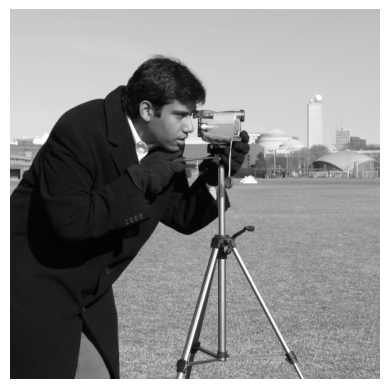

In [2]:
from skimage import data
import matplotlib.pyplot as plt

camera = data.camera()
plt.figure()
plt.imshow(camera.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

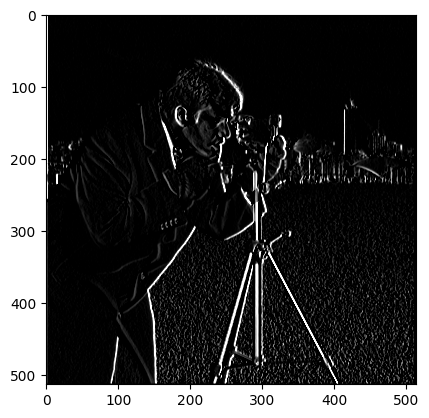

In [21]:
camera_vert_sobel = conv(camera, sobel_kernel_vert, 1, 2)
plt.imshow(camera_vert_sobel, cmap="gray", vmin=0, vmax=255);

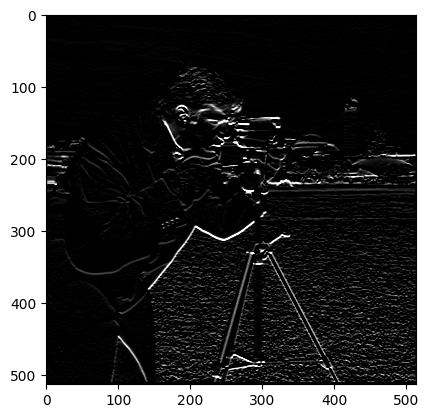

In [22]:
camera_hor_sobel = conv(camera, sobel_kernel_hor, 1, 2)
plt.imshow(camera_hor_sobel, cmap="gray", vmin=0, vmax=255);

Допишите код ниже и проинтерпретируйте полученный результат:

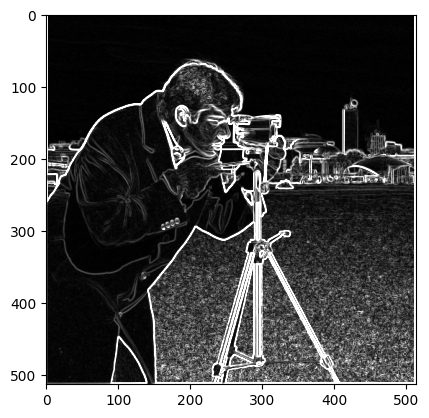

In [20]:
camera_s_hor_filter = conv(camera, sobel_kernel_vert, 1, 2)
camera_s_vert_filter = conv(camera, sobel_kernel_hor, 1, 2)
camera_with_borders = np.sqrt(camera_s_hor_filter**2 + camera_s_vert_filter**2)
plt.imshow(camera_with_borders, cmap="gray", vmin=0, vmax=255);

## Задание 2. AlexNet

**15 баллов**

Воссоздайте архитектуру `AlexNet` для определения заболевания растения. Датасеты уже созданы ниже.

In [53]:
INPUT_IMAGE_SIZE = 227
BATCH_SIZE = 64
N_EPOCHS = 25 # можно будет при желании увеличить
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
from IPython.display import clear_output

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, ToPILImage
from torchvision.transforms import Normalize, Resize

from glob import glob
from torch import nn
from torch.nn import functional as F
import torch
import os
 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [26]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

clear_output()

In [27]:
!unzip train.zip
!unzip validation.zip
!unzip test.zip

clear_output()

In [28]:
class BeanDataset(Dataset):
    def __init__(self, img_dir, side_size=INPUT_IMAGE_SIZE):
        # папка с картинками
        self.img_dir = img_dir
        # отсортированный список с названиями файлов
        self.files = sorted(glob(f'{img_dir}/*/*.jpg'))
        class_names = sorted(os.listdir(img_dir))
        # названия папок с картинками переведем в номера классов
        self.class_dir = {name:idx for idx, name in enumerate(class_names)}
        self._number_to_labels = {idx:name for idx, name in enumerate(class_names)}

        # трансформации данных: мы изменяем размер,
        # так как AlexNet работает с картинками 227 на 227 пикселей
        self.transforms = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor(),
                                  Normalize(
                                      mean = [0.5183, 0.4845, 0.6570],
                                      std = [0.2111, 0.2227, 0.2291]
                                  )])
        self._transforms_for_plot = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor()
                                  ])


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx, normalize=True):
        file_path = self.files[idx]
        image = read_image(file_path).type(torch.DoubleTensor)

        # применяем трансформации
        if normalize:
            transformed_img = self.transforms(image)
        
        transformed_img = self._transforms_for_plot(image)
        
        label_name = file_path.split('/')[-2]
        label = self.class_dir[label_name]
        
        # как обычно возвращаем картинку и номер класса
        return transformed_img, label

In [29]:
train_dataset = BeanDataset("./train/")
valid_dataset = BeanDataset("./validation/")
test_dataset = BeanDataset("./test/")

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Посмотрим на наши картинки:

(код довольно эзотерический, но у меня было такое настроение)

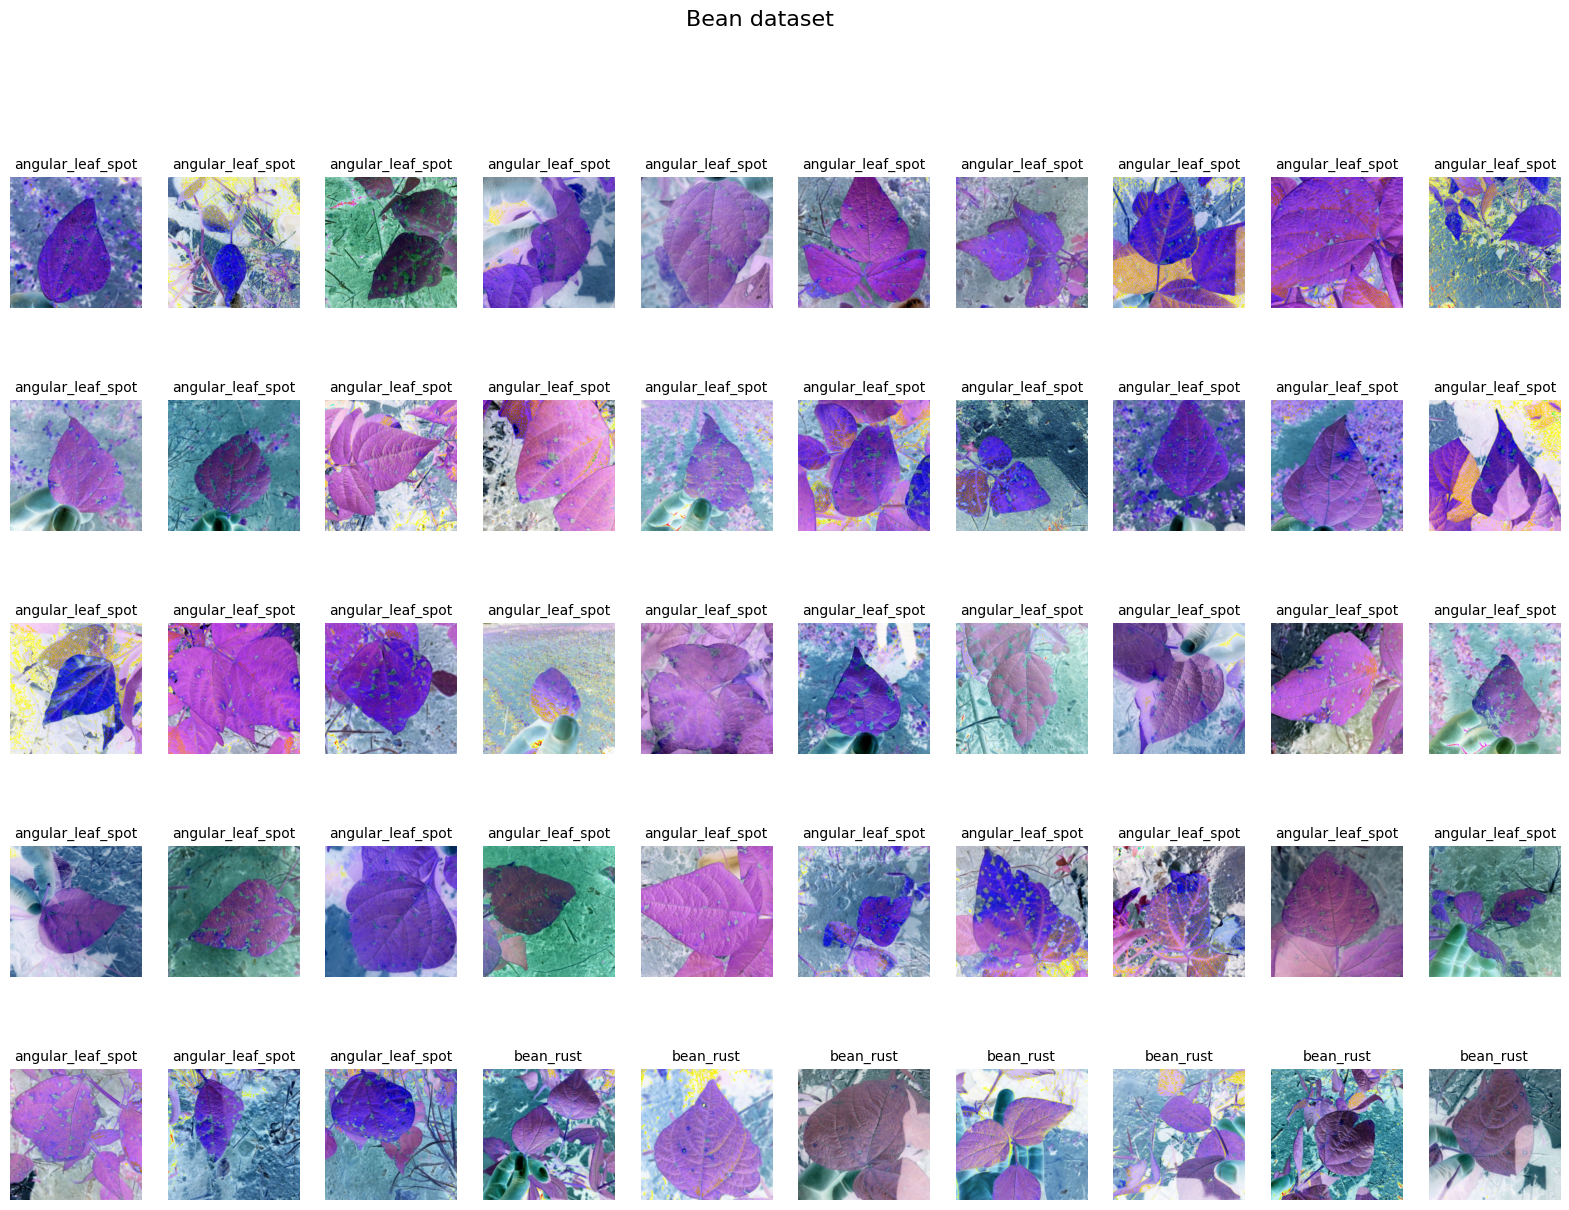

In [30]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    title = valid_dataset._number_to_labels[valid_dataset.__getitem__(index, normalize=False)[1]]
    plt.title(title, fontsize=10)
    
fig.suptitle("Bean dataset", fontsize=16);

### Реализация `AlexNet`

В лекции мы познакомились с архитектурой `AlexNet`, теперь пришло время реализовать ее самостоятельно. Важно, что на выходе число классов у нас будет сильно меньше чем 1000, нужно будет в начале это определить. Везде в качестве активации используется `ReLU`.

Также обратите внимание на параметры пулинга, тут ядро 3х3 со страйдом 2 (поэтому он называется overlapping).

Картинка может немного отличаться от того, что было на лекции, ориентируйтесь на картинку в ноутбуке.

Внимательно смотрите на параметры сверток (например, padding / stride).

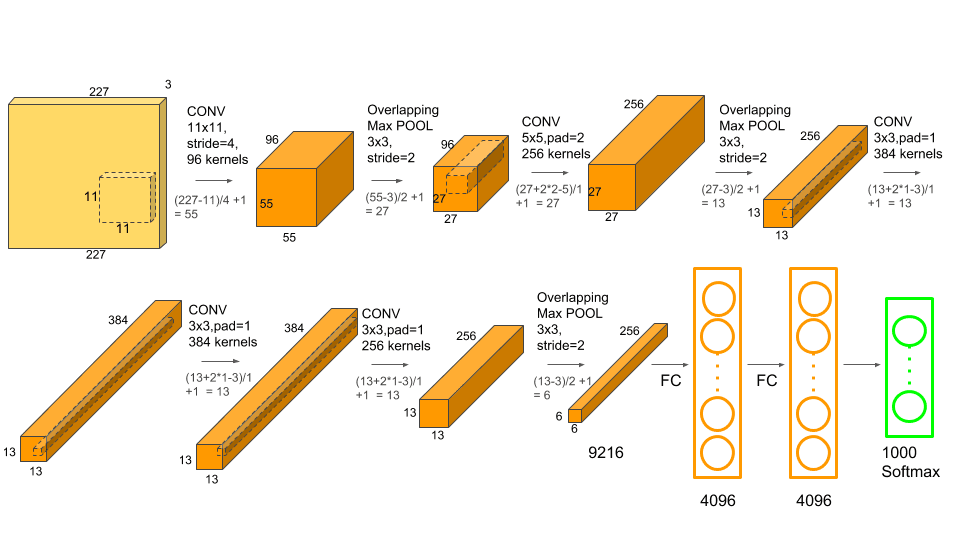

In [40]:
N_CLASSES = len(train_dataset.class_dir)
LEARNING_RATE = 3e-4

In [50]:
class AlexNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5 , padding=2, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3 , padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3 , padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3 , padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=9216, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=n_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

Возьмите код для обучения и валидации модели, который был на лекции (если захочется, то его можно как угодно менять). В лекции мы возвращали из модели помимо логитов еще и вероятности классов, чтобы потом рисовать красивые картинки. Если захотите сделать также, то учтите это.

In [43]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    """
    Function for the training step of the training loop
    """

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate_epoch(valid_loader, model, criterion, device):
    """
    Function for the validation step of the training loop
    """
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def get_accuracy(model, dataloader, device):
    """
    model - 
    dataloader - 
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy


def plot_losses(train_losses, valid_losses):
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=train_losses, label="Train Loss")
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=valid_losses, label="Validation Loss")


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    """
    Function defining the entire training loop
    """

    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate_epoch(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, train_losses, valid_losses

Выберите функцию потерь и оптимизатор и обучите полученную модель на тренировочных данных, параллельно проверяя ее на валидационной части:

In [51]:
model = AlexNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

10:23:39 --- Epoch: 0	Train loss: 1.1034	Valid loss: 1.0962	Train accuracy: 50.77	Valid accuracy: 52.63
10:24:31 --- Epoch: 1	Train loss: 1.0367	Valid loss: 1.0379	Train accuracy: 42.46	Valid accuracy: 42.86
10:25:25 --- Epoch: 2	Train loss: 1.0194	Valid loss: 0.9127	Train accuracy: 57.16	Valid accuracy: 56.39
10:26:23 --- Epoch: 3	Train loss: 0.8499	Valid loss: 0.7938	Train accuracy: 68.18	Valid accuracy: 69.17
10:27:19 --- Epoch: 4	Train loss: 0.8219	Valid loss: 0.7582	Train accuracy: 61.99	Valid accuracy: 65.41
10:28:16 --- Epoch: 5	Train loss: 0.7931	Valid loss: 1.0612	Train accuracy: 50.68	Valid accuracy: 48.87
10:29:13 --- Epoch: 6	Train loss: 0.8420	Valid loss: 0.6899	Train accuracy: 69.73	Valid accuracy: 70.68
10:30:08 --- Epoch: 7	Train loss: 0.7602	Valid loss: 0.7627	Train accuracy: 67.21	Valid accuracy: 66.92
10:31:04 --- Epoch: 8	Train loss: 0.7028	Valid loss: 0.6401	Train accuracy: 74.18	Valid accuracy: 75.19
10:32:00 --- Epoch: 9	Train loss: 0.6215	Valid loss: 0.6906	Trai

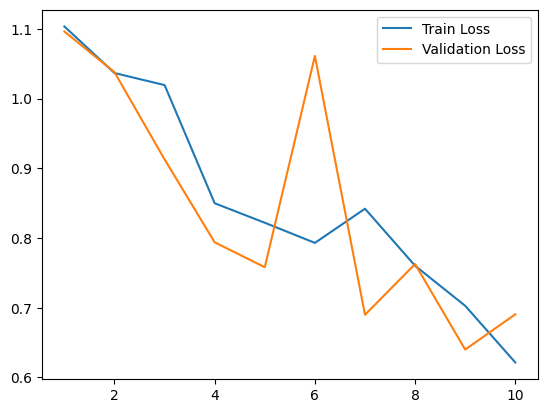

In [52]:
# На 10 эпохах модель пошатывало. Попробуем 25.
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

10:36:17 --- Epoch: 0	Train loss: 0.5344	Valid loss: 0.5381	Train accuracy: 78.43	Valid accuracy: 78.95
10:37:07 --- Epoch: 1	Train loss: 0.5993	Valid loss: 0.6045	Train accuracy: 74.66	Valid accuracy: 74.44
10:38:08 --- Epoch: 2	Train loss: 0.5174	Valid loss: 0.6069	Train accuracy: 79.11	Valid accuracy: 79.70
10:39:08 --- Epoch: 3	Train loss: 0.5081	Valid loss: 0.4574	Train accuracy: 84.43	Valid accuracy: 85.71
10:40:05 --- Epoch: 4	Train loss: 0.4222	Valid loss: 0.3657	Train accuracy: 85.01	Valid accuracy: 88.72
10:41:02 --- Epoch: 5	Train loss: 0.4121	Valid loss: 0.6253	Train accuracy: 74.95	Valid accuracy: 71.43
10:42:01 --- Epoch: 6	Train loss: 0.4892	Valid loss: 0.6903	Train accuracy: 83.37	Valid accuracy: 78.20
10:43:00 --- Epoch: 7	Train loss: 0.3947	Valid loss: 0.5861	Train accuracy: 79.79	Valid accuracy: 80.45
10:43:57 --- Epoch: 8	Train loss: 0.3621	Valid loss: 0.5206	Train accuracy: 83.46	Valid accuracy: 81.20
10:44:57 --- Epoch: 9	Train loss: 0.3324	Valid loss: 0.5182	Trai

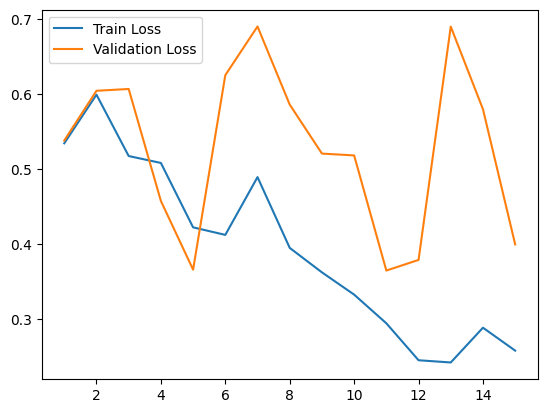

In [54]:
# Было немного лень запускать все заново, поэтому я запустил еще 15 эпох на уже обученной на 10 эпохах модели
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

Если вы все реализовали правильно, то `accuracy` на валидации должна быть в районе 0.8.

Лосс на валидации ведет себя как пьяный матрос на пристани -- пошатывается из стороны в сторону. Это нормально или причиной тому ошибки в коде?

### Визуализация предсказаний

Визуализируем предсказания нашей модели и степень уверенности в них. Сделайте выводы о качестве полученной модели.

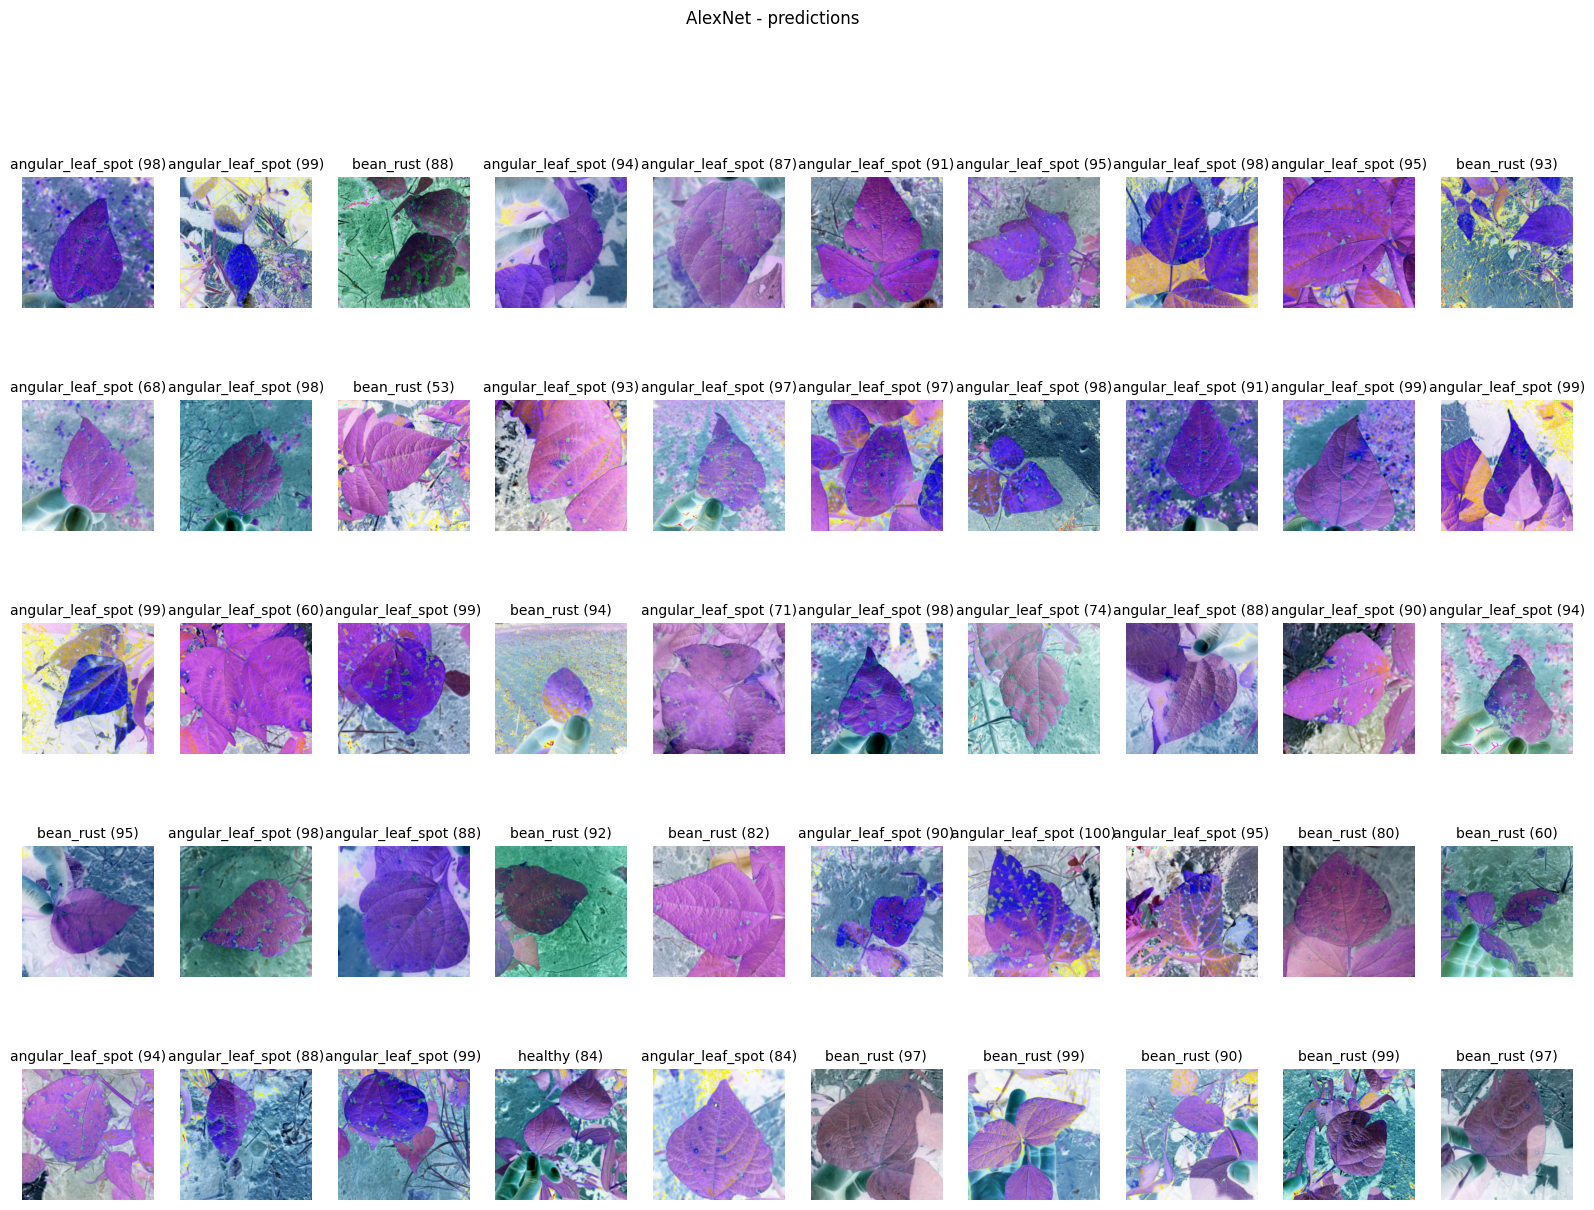

In [56]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    
    with torch.no_grad():
        # error)
        model.cpu().eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    title = f"{valid_dataset._number_to_labels[torch.argmax(probs).item()]} ({torch.max(probs * 100):.0f})"
    
    plt.title(title, fontsize=10)
fig.suptitle('AlexNet - predictions');

Вывод: модель качественная.

## Задание 3. И снова социализация

**1 дополнительный балл**

Однажды такое уже бывало, но почему бы не повторить. Сходите погулять вместе с одногруппниками или созвонитесь в зуме, а сюда прикрепите какие-нибудь фотографии и кратко опишите, на какие темы вы общались)

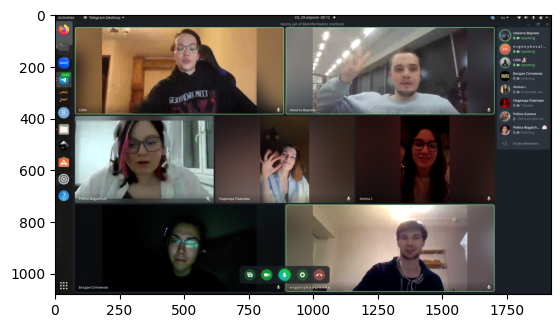

In [55]:
img = plt.imread("/home/asklepiad/Pictures/socialization_ml_2.png")
_ = plt.imshow(img)

Обсуждали бишкекские подвалы, армянский плов, географию Средней Азии и Закавказья, дисперсию, первый московский мед, яндекс.

Тут, как обычно, можно описать свои эмоции от выполнения этого задания:

**Ответ:**

В этот раз было достаточно несложно. Я все еще делаю задания довольно медленно и долго дебажу ошибки, которые весьма непросто создать даже специально, но в целом, либо уменьшается сложность заданий, либо модель BogdanSotnikov все-таки потихоньку обучается.